In [18]:
!pip install wordcloud
!pip install nltk
!pip install google-api-python-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.9 MB/s eta 0:00:0000:0100:01


In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import wordcloud
import requests
import re
import os
from googleapiclient.discovery import build

## 제공된 데이터 셋과 유사한 데이터 셋을 웹 스크랩핑 한 다음 wordcloud 만들기
- 어떤 거를 스크래핑 할지?
    - 유튜브 조회수 평균보다 높은거와 평균보다 낮은거를 구분해보자
    - 조회수 보다 높으면 1, 낮으면 0으로 라벨링 후 해당 영상들의 제목이나, 댓글 혹은 설명 글 활용.
    - =>>> 1000개 이상의 데이터를 활용할 수 있는 채널이 많이 있을까?
- 어떤 비즈니스 가치를 만들 수 있을지?
    - 유튜브 채널주가 영상을 촬영할 때 주제로써 참고할 수 있다. 

In [ ]:
API_KEY = ""

In [127]:
class YoutubeAPI():
    def __init__(self):
        # 잇섭 채널
        self.channel_id = "UCdUcjkyZtf-1WJyPPiETF1g"
        self.youtube = build('youtube', 'v3', developerKey=API_KEY)

    def get_video_lists(self):
        video_list = []
        try :
            res = self.youtube.channels().list(
                id = self.channel_id,
                part = "contentDetails"
            ).execute()
            playlist_id = res['items'][0]['contentDetails']['relatedPlaylists']['uploads']
            next_page = None
    
            while True :
                res = self.youtube.playlistItems().list(playlistId = playlist_id, part = 'snippet', maxResults = 100, pageToken=next_page).execute()
                video_list += res['items']
                next_page = res.get('nextPageToken')

                if next_page is None:
                    break
            return video_list
        except :
            print('API 호출 한도 초과')

    def get_vedio_info(self, video_id):
        res = self.youtube.videos().list(
            id = video_id,
            part = 'snippet, contentDetails, statistics'
        ).execute()
        item_dict = {}
        if res['items']:
            item = res['items'][0]
            item_dict = {
                'video_id' : video_id,
                'title': item['snippet']['title'],
                'description': item['snippet']['description'],
                'viewCount' : item['statistics']['viewCount'],
                'likeCount': item['statistics']['likeCount'],
                'commentCount' : item['statistics'].get('commentCount', None),
                'tags': " ".join(item['snippet'].get('tags',[])),
                'duration' : item['contentDetails']['duration'],
                'publishedAt': item['snippet']['publishedAt']
            }

        return item_dict

    def set_channel_id(self, channelID):
        self.channel_id = channelID


In [128]:
def extract_data(youtube):
    # youtube API 사용해서 데이터 불러오기
    try : 
        if not os.path.exists('{channel}_video_list.csv'.format(channel = youtube.channel_id)) :
            raise FileNotFoundError()
    except :
        video_list = youtube.get_video_lists()
    
        # 먼저 비디오 리스트 뽑아와서 csv로 저장
        rows = []
        for item in video_list:
            item_dict = {}
            item_dict['video_id'] = item['snippet']['resourceId']['videoId']
            item_dict['title'] = item['snippet']['title']
            item_dict['description'] = item['snippet']['description']
            item_dict['publishedAt'] = item['snippet']['publishedAt']
            rows.append(item_dict)
    
        df_video_list = pd.DataFrame(rows)
        df_video_list.to_csv('{channel}_video_list.csv'.format(channel = youtube.channel_id))
    
    finally :
        df_video_list = pd.read_csv('{channel}_video_list.csv'.format(channel = youtube.channel_id))


    try : 
        if not os.path.exists('{channel}_video_info_list.csv'.format(channel = youtube.channel_id)) :
            raise FileNotFoundError()
    except :
        # 영상 정보 가져오기 (조회수 좋아요)
        video_info_list = []
        for idx, row in df_video_list.iterrows():
            video_info = youtube.get_vedio_info(row['video_id'])
            video_info_list.append(video_info)
            print(f"\r진행 상황: {idx+1}/{len(df_video_list)} 요청 중...", end="")

        # CSV 파일로 저장하기
        df_video_info_list = pd.DataFrame(video_info_list)
        df_video_info_list.to_csv('{channel}_video_info_list.csv'.format(channel = youtube.channel_id))


In [147]:
def transform(df) :
    # 조회수
    # 분포 75% 이상 => 선호 컨텐츠
    # 분포 25% 이하 => 비선호 컨텐츠
    # 조회수 평균을 구하고, 평균 기준으로 sampling 하기

    q25 = df['viewCount'].describe()['25%']
    q75 = df['viewCount'].describe()['75%']
    
    df['prefer'] = df['viewCount'].apply(
        lambda x : 1 if x > q75 else (-1 if x < q25 else 0)
    )
    
    return df

In [166]:
def display(df) :
    # word_cloud 활용해서 데이터 보여주기
    df_prefer = df[df['prefer'] == 1]
    df_non_prefer = df[df['prefer'] == -1]

    df_prefer['title'] = df_prefer['title'].apply(lambda s : re.sub("[^가-힣 ]","",s))
    df_non_prefer['title'] = df_non_prefer['title'].apply(lambda s : re.sub("[^가-힣 ]","",s))

    prefer_text = " ".join(df_prefer["title"])
    non_prefer_text = " ".join(df_non_prefer["title"])

    word_cloud_prefer = wordcloud.WordCloud(max_words = 200, font_path="/System/Library/Fonts/AppleSDGothicNeo.ttc", colormap = "Blues")
    words_prefer = word_cloud_prefer.generate(prefer_text)

    word_cloud_non_prefer = wordcloud.WordCloud(max_words = 200, font_path="/System/Library/Fonts/AppleSDGothicNeo.ttc",  colormap = "Reds")   
    words_non_prefer = word_cloud_non_prefer.generate(non_prefer_text)

    plt.figure(figsize = (14,7))
    plt.subplot(2,1,1)
    plt.imshow(words_prefer)
    plt.axis("off")
    plt.title("Prefer Contents")
    
    plt.figure(figsize = (14,7))
    plt.subplot(2,1,1)
    plt.imshow(words_non_prefer)
    plt.axis("off")
    plt.title("Non - Prefer Contents")

    
    plt.tight_layout()
    plt.show()
    

/var/folders/cw/5cxz2ybs5ls_6q0108849sb40000gn/T/ipykernel_62992/4768668.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prefer['title'] = df_prefer['title'].apply(lambda s : re.sub("[^가-힣 ]","",s))
/var/folders/cw/5cxz2ybs5ls_6q0108849sb40000gn/T/ipykernel_62992/4768668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_prefer['title'] = df_non_prefer['title'].apply(lambda s : re.sub("[^가-힣 ]","",s))
findfont: Font family 'AppleSDGothicNeo' not found.
findfont: Font family 'AppleSDGothicNeo'

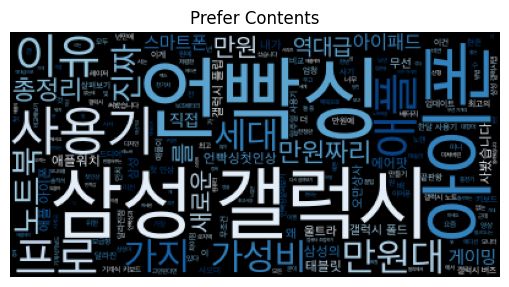

findfont: Font family 'AppleSDGothicNeo' not found.
findfont: Font family 'AppleSDGothicNeo' not found.
findfont: Font family 'AppleSDGothicNeo' not found.
findfont: Font family 'AppleSDGothicNeo' not found.
findfont: Font family 'AppleSDGothicNeo' not found.
findfont: Font family 'AppleSDGothicNeo' not found.
findfont: Font family 'AppleSDGothicNeo' not found.
findfont: Font family 'AppleSDGothicNeo' not found.
findfont: Font family 'AppleSDGothicNeo' not found.
findfont: Font family 'AppleSDGothicNeo' not found.
findfont: Font family 'AppleSDGothicNeo' not found.
findfont: Font family 'AppleSDGothicNeo' not found.


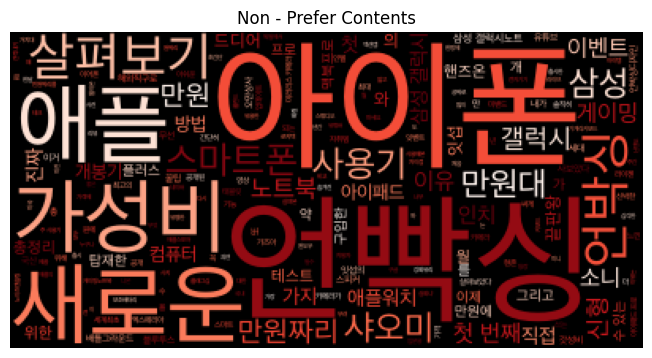

In [167]:
def ETL():
    youtube = YoutubeAPI()
    extract_data(youtube)

    df_video_list = pd.read_csv('{channel}_video_info_list.csv'.format(channel = youtube.channel_id))
    transformed_data = transform(df_video_list)
    display(transformed_data)
    
ETL()